## Import libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import warnings
import datetime
import scipy.stats as stats
from scipy.stats import f_oneway 
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix



warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Data Preprocessing

### Load data and Redo the Processing that done in EDA

In [10]:
# Read the CSV file into a DataFrame(dfloan)
dfloan = pd.read_csv('../data/loan_data_2007_2014.csv', low_memory=False)

# Dropping unnecessary columns from the dataframe
dfloan = dfloan.drop(columns=['id', 'member_id', 'Unnamed: 0'], axis=1)

# Define a function to map loan status to 'Good Loan' or 'Bad Loan'
def map_loan_status(status):
    """
    Function to map loan status to 'Bad Loan' or 'Good Loan'.
    
    Parameters:
    status (str): The loan status to be mapped.
    
    Returns:
    str: 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise.
    """
    
    # List of loan statuses that imply a default
    default_statuses = [
        'Charged Off', 
        'Late (31-120 days)', 
        'Late (16-30 days)',
        'Default',
        'Does not meet the credit policy. Status:Charged Off'
    ]
    
    # Return 'Bad Loan' if the status is in the list of default statuses, 'Good Loan' otherwise
    return 'Bad Loan' if status in default_statuses else 'Good Loan'

# Apply the map_loan_status function to each status in the 'loan_status' column
dfloan['loan_status'] = dfloan['loan_status'].apply(map_loan_status)

# Convert the 'issue_d' column to datetime format with 'Oct-14' style dates
dfloan['issue_d'] = pd.to_datetime(dfloan['issue_d'], format='%b-%y')

# Extract the year from the datetime object ad store it in a new column 'years'
dfloan['years'] = dfloan['issue_d'].dt.year


# Define a list of state abbreviations that belong to the West region
West = [
    'CA',  # California
    'NV',  # Nevada
    'UT',  # Utah
    'CO',  # Colorado
    'WY',  # Wyoming
    'MT',  # Montana
    'ID',  # Idaho
    'OR',  # Oregon
    'WA',  # Washington
    'AK',  # Alaska
    'HI'   # Hawaii
]

# Define a list of state abbreviations that belong to the Southwest region
Southwest = [
    'AZ',  # Arizona
    'NM',  # New Mexico
    'TX',  # Texas
    'OK'   # Oklahoma
]

# Define a list of state abbreviations that belong to the Midwest region
Midwest = [
    'ND',  # North Dakota
    'MN',  # Minnesota
    'SD',  # South Dakota
    'NE',  # Nebraska
    'KS',  # Kansas
    'MO',  # Missouri
    'IA',  # Iowa
    'WI',  # Wisconsin
    'IL',  # Illinois
    'IN',  # Indiana
    'OH',  # Ohio
    'MI'   # Michigan
]

# Define a list of state abbreviations that belong to the Southeast region
Southeast = [
    'AR',  # Arkansas
    'LA',  # Louisiana
    'MS',  # Mississippi
    'AL',  # Alabama
    'GA',  # Georgia
    'TN',  # Tennessee
    'KY',  # Kentucky
    'NC',  # North Carolina
    'SC',  # South Carolina
    'WV',  # West Virginia
    'DC',  # District of Columbia
    'VA',  # Virginia
    'DE',  # Delaware
    'FL'   # Florida
]

# Define a list of state abbreviations that belong to the Northeast region
Northeast = [
    'PA',  # Pennsylvania
    'MD',  # Maryland
    'NJ',  # New Jersey
    'NY',  # New York
    'CT',  # Connecticut
    'RI',  # Rhode Island
    'MA',  # Massachusetts
    'NH',  # New Hampshire
    'VT',  # Vermont
    'ME'   # Maine
]

def us_region(state):
    """
    Function to map US state to its corresponding region.

    Parameters:
    state (str): The US state abbreviation.

    Returns:
    str: The region where the state is located.
    """
    # Check if the state is in the West region
    if state in West:
        return 'West'
    # Check if the state is in the Southwest region
    elif state in Southwest:
        return 'Southwest'
    # Check if the state is in the Midwest region
    elif state in Midwest:
        return 'Midwest'
    # Check if the state is in the Southeast region
    elif state in Southeast:
        return 'Southeast'
    # Check if the state is in the Northeast region
    elif state in Northeast:
        return 'Northeast'
    # If the state is not in any of the defined regions, return 'Other'
    else:
        return 'Other'

# Apply the function us_region to 'addr_state' column
# This will create a new column 'region' in the dataframe dfloan
dfloan['region'] = dfloan['addr_state'].apply(us_region)

### Drop Columns with High Missing Values

In [11]:
def dropnan(data, threshold):
    """
    Function to drop columns with missing values above a certain threshold.
    
    Parameters:
    data (DataFrame): The data to be cleaned.
    threshold (float): The threshold proportion of missing values, columns above threshold which will be dropped.
    
    Returns:
    DataFrame: The cleaned data with columns dropped based on the threshold.

    Examples:
    >>> dropnan(dfloan, 0.5)
    """

    # Iterate over each column in the DataFrame
    for column in data.columns:
        
        # Calculate the proportion of missing values in the current column
        missing_values = data[column].isnull().sum() / len(data)

        # if the proportion of missing values is greatwer than the threshold
        if missing_values > threshold:
            
            # Drop the current column from the DataFrame
            data = data.drop(columns=column, axis=1)
    
    # Return the cleaned DataFrame
    return data

In [12]:
# Drop the columns with missing values above the threshold
dfloan_cleaned = dropnan(dfloan, 0.4)

print(dfloan.shape)
print(dfloan_cleaned.shape)

(466285, 74)
(466285, 52)


In [13]:
# potential_bin = ['delinq_2yrs', ]

### Drop Uneccessary Columns

In [14]:
not_necessary_col = ['sub_grade', 'emp_title', 'pymnt_plan', 'url', 'zip_code', 'title', 'addr_state',
                     'total_acc', 'out_prncp_inv','total_pymnt_inv', 'total_rec_late_fee', 
                     'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med',
                     'application_type', 'policy_code', 'acc_now_delinq', 'years']
dfloan_cleaned1 = dfloan_cleaned.drop(columns=not_necessary_col, axis=1)

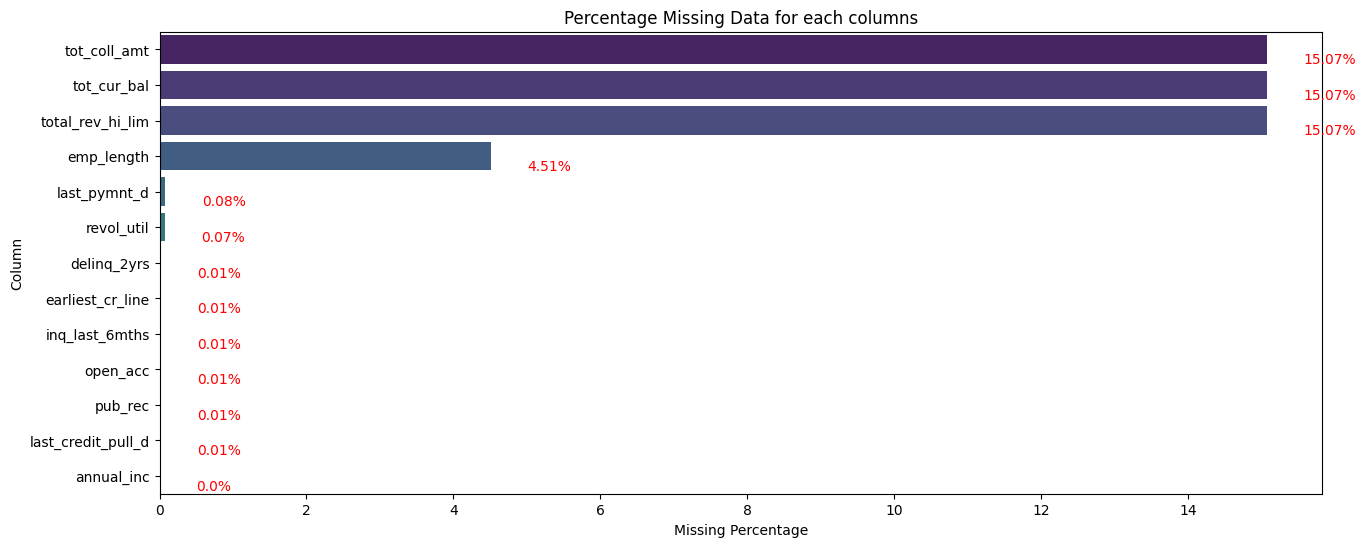

In [15]:
def plot_missing_value(data):
    # Calculate the percentage of missing values in each column
    missing = (data.isnull().sum() / len(data)) * 100
    
    # Filter out the columns that have no missing values
    missing = missing[missing>0]

    # Create a DataFrame from the missing data
    missing_data = pd.DataFrame({'Column': missing.index, 
                                 'Missing%': np.round(missing.values, 2)
    })

    # Sort the DataFrame by the percentage of missing values in descending order
    missing_data = missing_data.sort_values('Missing%', ascending=False)

    # Create a bar plot of the missing data
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x='Missing%', y='Column', data=missing_data, palette='viridis')

    # Add the percentage of missing data as text on the bars
    for i, v in enumerate(missing_data['Missing%']):
        ax.text(v + 0.5, i + .4, str(v) + '%', color='red')

    # Set the labels and title of the plot
    ax.set_xlabel('Missing Percentage')
    ax.set_title('Percentage Missing Data for each columns')

plot_missing_value(dfloan_cleaned1)


### Train Test Split

In [16]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1103)

print(f'X train shape: {X_train.shape}')
print(f'y train shape:{y_train.shape}')

print(f'\nX test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X train shape: (326399, 33)
y train shape:(326399, 1)

X test shape: (139886, 33)
y_test shape: (139886, 1)


### Impute rest of missing values

In [17]:
# define funtion to fill numerical missing values with median and categorical missing values with mode
def fillnan(data):
    """
    Function to fill missing values in a DataFrame. Numeric columns are filled with the median of the column,
    while categorical/non-numeric columns are filled with the mode.

    Parameters:
    data (DataFrame): The DataFrame to be cleaned.

    Returns:
    DataFrame: The cleaned DataFrame with missing values filled.

    Examples:
    >>> fillnan(data)

    """
    
    # Iterate over each column in the DataFrame
    for column in data.columns:

        # Check if the current column is numeric
        if data[column].dtype in ['int64', 'float64']:
            # Fill missing values with the median of the column
            data[column] = data[column].fillna(data[column].median())
        else:
            # Fill missing values with the mode of the column
            data[column] = data[column].fillna(data[column].mode()[0])
    # Return the cleaned DataFrame
    return data

# Fill missing values in the train set
X_train_clean = fillnan(X_train)

### Feature Selection

#### Chi Square Test for Categorical Columns

In [18]:
cat_select = X_train_clean.select_dtypes('object')

for column in cat_select.columns:
    contingency_table = pd.crosstab(X_train_clean[column], y_train['loan_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print(f'{column} is dependent on loan_status')
    else:
        print(f'{column} is independent on loan_status')

term is dependent on loan_status
grade is dependent on loan_status
emp_length is dependent on loan_status
home_ownership is dependent on loan_status
verification_status is dependent on loan_status
purpose is dependent on loan_status
earliest_cr_line is dependent on loan_status
initial_list_status is dependent on loan_status
last_pymnt_d is dependent on loan_status
last_credit_pull_d is dependent on loan_status
region is dependent on loan_status


#### Correlation Matrix for Numerical Columns

<Axes: >

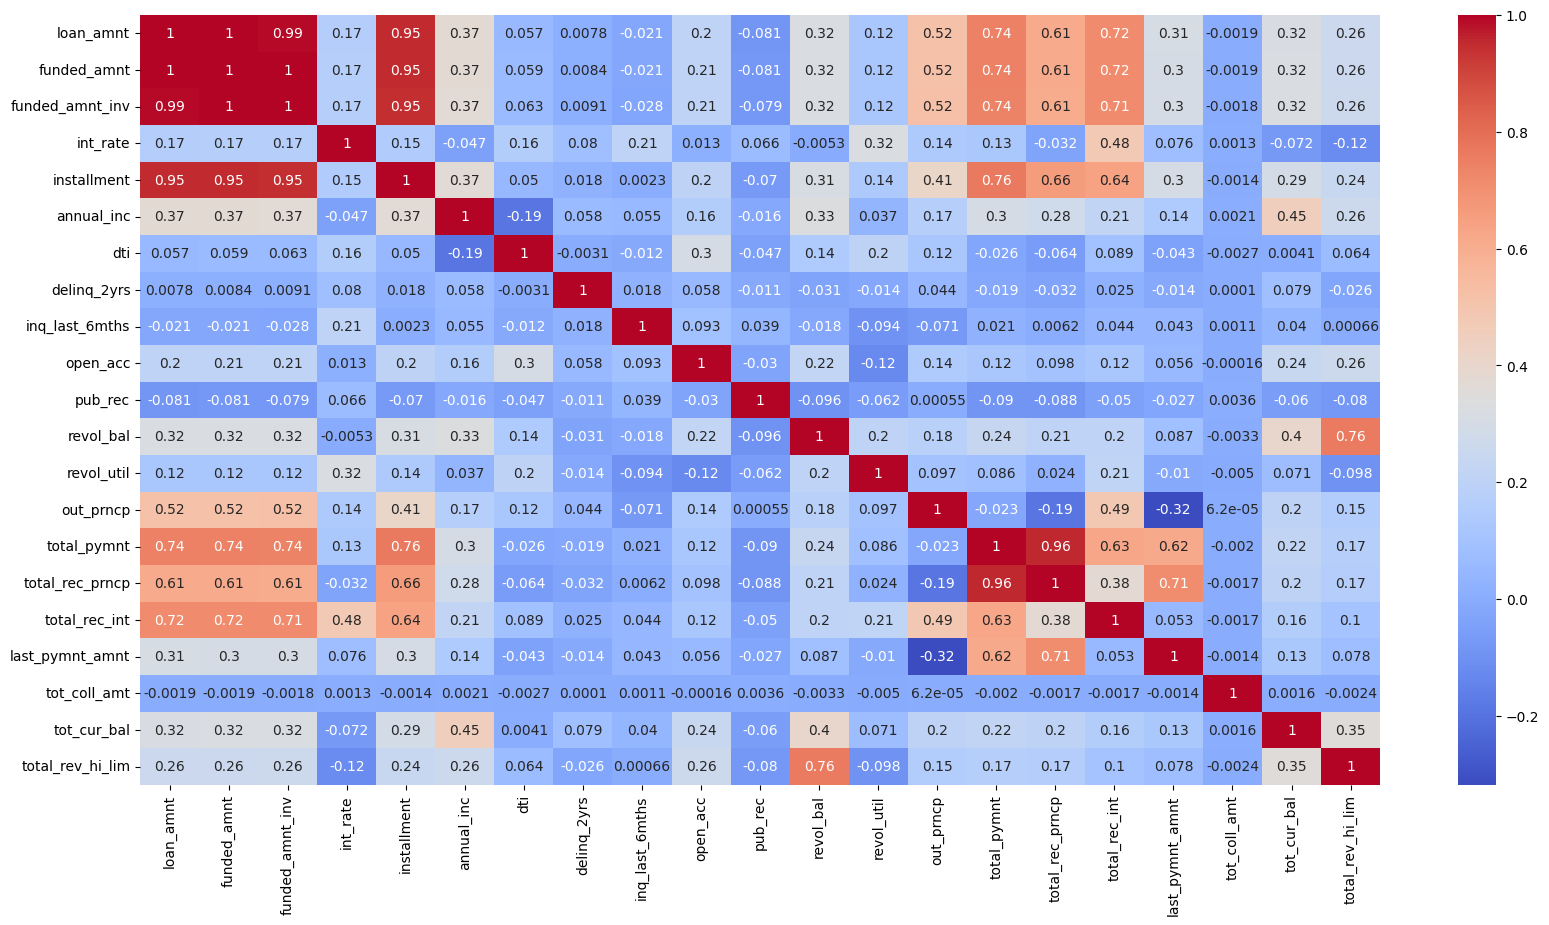

In [19]:
nums = X_train_clean.select_dtypes('number')

dfcorr = nums.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(dfcorr, cmap='coolwarm', annot=True)

In [20]:
# Drop multicollinearity columns
multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

#### ANOVA Test for Numerical Columns

<Axes: xlabel='p_value', ylabel='column'>

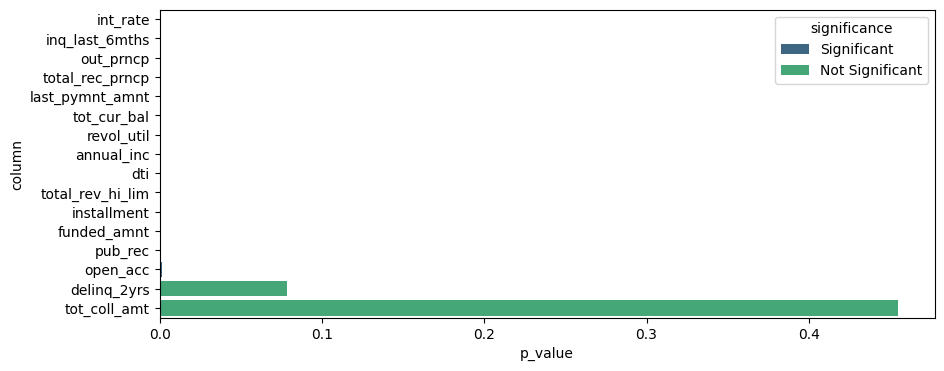

In [21]:
df_temp = pd.concat([X_train_nomulti, y_train], axis=1)
new_nums = df_temp.select_dtypes('number')

anova_results = pd.DataFrame(columns=['column', 'f_score', 'p_value', 'significance'])

# Perform ANOVA for each numerical column with respect to the target
for i, column in enumerate(new_nums.columns):
    # Separate the data based on the categories in the target
    good = df_temp[column][df_temp['loan_status'] == 'Good Loan']
    bad = df_temp[column][df_temp['loan_status'] == 'Bad Loan']
    
    # Perform the ANOVA test
    f_statistic, p_value = f_oneway(good, bad)

    # Determine the significance
    if p_value < 0.05:
        significance = 'Significant'
    else:
        significance = 'Not Significant'
    
    # Append the results to the DataFrame
    anova_results.loc[i] = [column, f_statistic, p_value, significance]

anova_results = anova_results.sort_values('p_value')

plt.figure(figsize=(10, 4))
sns.barplot(x='p_value', y='column', hue='significance', data=anova_results, palette='viridis')

`delinq_2yrs` and `tot_coll_amt` are not significant in ANOVA test, so we can drop them.

In [22]:
not_sig = ['delinq_2yrs', 'tot_coll_amt']
X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

### Further Feature Engineering

In [50]:
# X = dfloan_cleaned1.drop(columns=['loan_status'])
# y = dfloan_cleaned1[['loan_status']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1103)

# # Fill missing values in the train and test
# X_train_clean = fillnan(X_train)

# X_test_clean = fillnan(X_test)

# # Drop multicollinearity columns
# multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

# X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

# X_test_nomulti = X_test_clean.drop(columns=multi_col, axis=1)

# not_sig = ['delinq_2yrs', 'tot_coll_amt']
# X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

# X_test_selected = X_test_nomulti.drop(columns=not_sig, axis=1)

In [23]:
X = dfloan_cleaned1.drop(columns=['loan_status'])
y = dfloan_cleaned1[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1103)

X_train_clean = fillnan(X_train)

# Drop multicollinearity columns
multi_col = ['loan_amnt', 'funded_amnt_inv', 'total_rec_int', 'total_pymnt', 'revol_bal']

X_train_nomulti = X_train_clean.drop(columns=multi_col, axis=1)

not_sig = ['delinq_2yrs', 'tot_coll_amt']
X_train_selected = X_train_nomulti.drop(columns=not_sig, axis=1)

#### Feature Creation

In [24]:
# Create a copy of the selected features for further feature engineering
X_train_eng = X_train_selected.copy()

# Define a function to convert a date column into two new columns
def days_month_converter(data, date_col):
    """
    This function converts a date column into two new columns:
    1. days_since_{date_col}: Number of days from the date to the current date.
    2. {date_col}_month: The month of the date.

    Parameters:
    data (DataFrame): The DataFrame containing the date column.
    date_col (str): The name of the date column to convert.

    Returns:
    DataFrame: The updated DataFrame with the new columns and the original date column dropped.

    Examples:
    >>> days_month_converter(dfloan_cleaned, 'issue_d')
    """

    # Convert the date column to datetime format
    data[date_col] = pd.to_datetime(data[date_col], format='%b-%y')

    # Get the current date
    current_date = datetime.datetime.now()

    # Create a new column for the number of days from the date to the current date
    data[f"days_since_{date_col}"] = (current_date - data[date_col]).dt.days

    # Create a new column for the month of the date
    data[f"{date_col}_month"] = data[date_col].dt.month

    # Drop the original date column
    data = data.drop(columns=date_col, axis=1)

    return data

# List of date columns to convert
dates = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']

# Convert the date columns in the list to days and month columns
for date in dates:
   X_train_eng = days_month_converter(X_train_eng, date)


# For 'pub_rec' column, if the value is greater than 0, replace it with 'no', otherwise replace it with 'yes'
X_train_eng['pub_rec'] = X_train_eng['pub_rec'].apply(lambda x: 'no' if x > 0 else 'yes')

# Create a mapping for 'initial_list_status' column
map_istatus = {
    'f': 'fractional',
    'w': 'whole'
}

# Apply the mapping to 'initial_list_status' column
X_train_eng['initial_list_status'] = X_train_eng['initial_list_status'].map(map_istatus)

# Create a mapping for 'home_ownership' column
map_home = {
    'NONE': 'OTHER'  # Map 'NONE' to 'OTHER'
}

# Apply the mapping to 'home_ownership' column
X_train_eng['home_ownership'] = X_train_eng['home_ownership'].replace(map_home)

#### Feature Encoding

In [25]:
# create a copy of X_train
X_train_enc = X_train_eng.copy()

# List of columns to be one-hot encoded
col_to_ohe = X_train_enc.select_dtypes('object').columns

# Perform one-hot encoding on each column in the list
for column in col_to_ohe:
    # Create dummy variables for each unique category in the column
    dummies = pd.get_dummies(X_train_enc[column], drop_first=True, prefix=f'{column}:').astype(int)
    
    # Concatenate the dummy variables with the original DataFrame
    X_train_enc = pd.concat([X_train_enc, dummies], axis=1)
    
    # Drop the original column from the DataFrame
    X_train_enc.drop(columns=column, axis=1, inplace=True)


# Define a mapping for 'loan_status' column values
map_target = {
    'Good Loan': 0,  # Map 'Good Loan' to 0
    'Bad Loan': 1    # Map 'Bad Loan' to 1
}

# Apply the mapping to the target train and test
y_train['loan_status'] = y_train['loan_status'].map(map_target)

### Feature Scaling

In [59]:
# Select numerical columns from the DataFrame, excluding 'pub_rec'
num_scale = X_train_eng.select_dtypes('number')

# Initialize a StandardScaler
scaler = StandardScaler()

# Scale the numerical columns and convert the result into a DataFrame
X_scale = pd.DataFrame(scaler.fit_transform(num_scale))

# Assign the original column names to the scaled DataFrame
X_scale.columns = num_scale.columns

# Drop the numerical columns from the encoded DataFrame
X_train_catenc = X_train_enc.drop(columns=num_scale.columns)

# Make sure the indices of the encoded DataFrame match with the original DataFrame
X_train_catenc.index = X_train_selected.index
X_scale.index = X_train_selected.index

# Concatenate the scaled numerical DataFrame and the encoded categorical DataFrame
X_train_scaled = pd.concat([X_scale, X_train_catenc], axis=1)

In [60]:
smot = SMOTE(random_state=1103)

X_train_ovr, y_train_ovr = smot.fit_resample(X_train_scaled, y_train)

print(f"Target before Resampled:\n{y_train.value_counts()}")
print(f"\nTarget after Resampled:\n{y_train_ovr.value_counts()}")

Target before Resampled:
loan_status
0              289916
1               36483
Name: count, dtype: int64

Target after Resampled:
loan_status
0              289916
1              289916
Name: count, dtype: int64


### Update all the processing to data Test
(Handle missing values & Feature encoding only)

In [61]:
X_test_clean = fillnan(X_test)

X_test_nomulti = X_test_clean.drop(columns=multi_col, axis=1)

X_test_selected = X_test_nomulti.drop(columns=not_sig, axis=1)

X_test_eng = X_test_selected.copy()

# Convert the date columns in the list to days and month columns
for date in dates:
   X_test_eng = days_month_converter(X_test_eng, date)

X_test_eng['pub_rec'] = X_test_eng['pub_rec'].apply(lambda x: 'no' if x == 0 else 'yes')

X_test_eng['initial_list_status'] = X_test_eng['initial_list_status'].map(map_istatus)

map_home = {
    'NONE': 'OTHER',  # Map 'NONE' to 'OTHER'
    'ANY': 'OTHER' # Map 'ANY' to 'OTHER'
}

# Apply the mapping to the 'home_ownership' column
X_test_eng['home_ownership'] = X_test_eng['home_ownership'].replace(map_home)

# create a copy of X_train
X_test_enc = X_test_eng.copy()

# List of columns to be one-hot encoded
col_to_ohe = X_test_enc.select_dtypes('object').columns

# Perform one-hot encoding on each column in the list
for column in col_to_ohe:
    # Create dummy variables for each unique category in the column
    dummies = pd.get_dummies(X_test_enc[column], drop_first=True, prefix=f'{column}:').astype(int)
    
    # Concatenate the dummy variables with the original DataFrame
    X_test_enc = pd.concat([X_test_enc, dummies], axis=1)
    
    # Drop the original column from the DataFrame
    X_test_enc.drop(columns=column, axis=1, inplace=True)

# Apply the mapping to the target train and test
y_test['loan_status'] = y_test['loan_status'].map(map_target)

### Modeling

In [20]:
# lr = LogisticRegression(random_state=1103)

# def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
#     model.fit(X_train, y_train)

#     train_pred = model.predict_proba(X_train)[:, 1]
#     test_pred = model.predict_proba(X_test)[:, 1]

#     # print the score with the roc auc score
#     train_auc = roc_auc_score(y_train, train_pred)
#     test_auc = roc_auc_score(y_test, test_pred)
#     print(f"Train AUC: {train_auc}")
#     print(f"Test AUC: {test_auc}")

#     train_recall = recall_score(y_train, train_pred > threshold)
#     test_recall = recall_score(y_test, test_pred > threshold)
#     print(f"Train Recall: {train_recall}")
#     print(f"Test Recall: {test_recall}")

#     train_precision = precision_score(y_train, train_pred > threshold)
#     test_precision = precision_score(y_test, test_pred > threshold)
#     print(f"Train Precision: {train_precision}")
#     print(f"Test Precision: {test_precision}")

#     train_f1 = f1_score(y_train, train_pred > threshold)
#     test_f1 = f1_score(y_test, test_pred > threshold)
#     print(f"Train F1: {train_f1}")
#     print(f"Test F1: {test_f1}")

    

In [21]:
# X_clean = fillnan(X)

# X_nomulti = X_clean.drop(columns=multi_col, axis=1)

# X_selected = X_nomulti.drop(columns=not_sig, axis=1)

# X_enc = X_selected.copy()

# for column in col_to_fencode:
#     X_enc = frequency_encoding(X_enc, column)

# # drop columns in col_to_fencode
# X_enc = X_enc.drop(columns=col_to_fencode, axis=1)

# # Define a mapping for 'home_ownership' column values
# map_home = {
#     'NONE': 'OTHER',  # Map 'NONE' to 'OTHER'
#     'ANY': 'OTHER' # Map 'ANY' to 'OTHER'
# }

# X_enc['home_ownership'] = X_enc['home_ownership'].replace(map_home)

# # Perform one-hot encoding on each column in the list
# for column in col_to_ohe:
#     # Create dummy variables for each unique category in the column
#     dummies = pd.get_dummies(X_enc[column], drop_first=True, prefix=f'{column}:').astype(int)
    
#     # Concatenate the dummy variables with the original DataFrame
#     X_enc = pd.concat([X_enc, dummies], axis=1)
    
#     # Drop the original column from the DataFrame
#     X_enc.drop(columns=column, axis=1, inplace=True)

# y['loan_status'] = y['loan_status'].map(map_target)

#### Define function to Evaluate Model

In [62]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_pred_proba = model.predict_proba(X_train)[:, 1]  
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # print the score with the roc auc score
    train_auc = roc_auc_score(y_train, train_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)

    train_recall = recall_score(y_train, train_pred_proba > threshold)
    test_recall = recall_score(y_test, test_pred_proba > threshold)

    train_precision = precision_score(y_train, train_pred_proba > threshold)
    test_precision = precision_score(y_test, test_pred_proba > threshold)

    train_f1 = f1_score(y_train, train_pred_proba > threshold)
    test_f1 = f1_score(y_test, test_pred_proba > threshold)

    scoredict = {
        'Model': 'LogisticRegression', 
        'AUC_train': [train_auc], 
        'AUC_test': [test_auc],
        'Recall_train': [train_recall],
        'Recall_test': [test_recall],
        'Precision_train': [train_precision],
        'Precision_test': [test_precision],
        'F1_train': [train_f1], 
        'F1_test': [test_f1]
    }

    df_eval = pd.DataFrame(scoredict)
    
    display(df_eval)

    # score = cross_validate(model, X_enc, y, cv=5, scoring='roc_auc', return_train_score=True)
    # print('ROC-AUC (crossval train):' + str(score['train_score']))
    # print('Mean ROC-AUC (crossval train):' + str(score['train_score'].mean()))
    # print('ROC-AUC (crossval test):' + str(score['test_score']))
    # print('Mean ROC-AUC (crossval test):' + str(score['test_score'].mean()))

#### Train and Evaluate Model 

In [65]:
lr = LogisticRegression(random_state=1103)

evaluate_model(lr, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.8)

,Model,AUC_train,AUC_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_train,F1_test
0,LogisticRegression,0.994614,0.781148,0.92166,0.932115,0.995652,0.241332,0.957228,0.383398


#### Hyperparameter Tuning

In [76]:
# Hyperparameter tuning Logistic Regression
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters to tune
param_dist = {
    'C': np.linspace(0.001, 1, num=60),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'newton-cholesky'],
    'max_iter': [250, 500, 1000, 2500, 5000]
}

# Initialize a RandomizedSearchCV object
rs = RandomizedSearchCV(lr, param_dist, n_iter=100, scoring='roc_auc', cv=5, n_jobs=-1, random_state=1103)

# Fit the RandomizedSearchCV object
rs.fit(X_train_ovr, y_train_ovr)

# Get the best hyperparameters
best_params = rs.best_params_
print(best_params)

In [ ]:
# tune in hyperparameter
lr_tuned = LogisticRegression()

In [ ]:
Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test
0	LogisticRegression	0.989574	0.765376	0.967431	0.940858	0.913723	0.22545	0.93981	0.36374

In [ ]:
Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test
0		0.989935	0.762468	 0.967842	     0.944087	 0.918649	     0.22146	    0.942604	0.358763

In [ ]:
Model	AUC_train	AUC_test	Recall_train	Recall_test	Precision_train	Precision_test	F1_train	F1_test
0	LogisticRegression	0.980413	0.721684	0.855664	0.974993	0.998866	0.188812	0.921736	0.316359

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1103)
evaluate_model(rf, X_train_ovr, y_train_ovr, X_test_enc, y_test, 0.5)

In [24]:
# X_test_clean = fillnan(X_test)